In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import os

import sys
sys.path.append('/sdf/home/c/carsmith/flash_reconstruction/siren-lartpc')
sys.path.append('..')

In [2]:
import time
from math import ceil
from pathlib import Path

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.tensorboard
import numpy as np
import yaml
from make_waveform import BatchedLightSimulation, mod0_sampler
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm, trange

device = torch.device('cuda:0')

2025-06-26 15:14:23.214581: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750976063.232492 3616528 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750976063.238082 3616528 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-26 15:14:23.256068: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Inputs
from make_waveform import *

nphoton = int(1e6)
nbatch = 1
inputs = mod0_sampler.batch_sample(nphoton=(nphoton), nbatch=nbatch) # shape (nbatch, ndet, nticks)
print(inputs.shape)
'''
input shape: (nbatch, ndet, nticks)
choose to only look at first 2D timing distribution in batch
We know photons can only be in time ticks 2560 - 2570 out of 16000

for one batch:
    for each det:
        for each tick:
            for each photon:
                sample a time delay using scintillation_model
'''

torch.Size([1, 48, 16000])


'\ninput shape: (nbatch, ndet, nticks)\nchoose to only look at first 2D timing distribution in batch\nWe know photons can only be in time ticks 2560 - 2570 out of 16000\n\nfor one batch:\n    for each det:\n        for each tick:\n            for each photon:\n                sample a time delay using scintillation_model\n'

BatchedLightSimulation Config:
	SINGLET_FRACTION: uniform(0.1, 0.5)
	LIGHT_OSCILLATION_PERIOD: uniform(0.05, 0.20)
	LIGHT_RESPONSE_TIME: uniform(0.01, 0.10)
	LIGHT_GAIN: uniform(-50.0, -20.0)
	TAU_S: uniform(0.0001, 0.01)
	TAU_T: uniform(0.9, 2.1)
	
	NOMINAL_SINGLET_FRACTION: 0.000000001 #0.35
	NOMINAL_LIGHT_OSCILLATION_PERIOD: 0.11     # us
	NOMINAL_LIGHT_RESPONSE_TIME: 0.055         # us^-1
	NOMINAL_TAU_S: 0.001                       # us
	NOMINAL_TAU_T: 1.530                       # us
	NOMINAL_LIGHT_GAIN: -45.0                  # ADC us/pe
	
	LIGHT_TICK_SIZE: 0.001
	LIGHT_WINDOW: [1, 10]


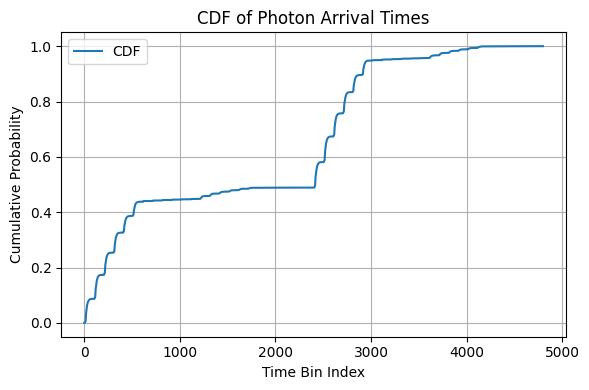

In [4]:
sim = BatchedLightSimulation(cfg="templates/waveform_sim.yaml").to(device) # gives input / "true" 2D timing distribution

# CDF used by mod0_sampler
data_path = 'data/lightLUT_Mod0_06052024_32.1.16_time_dist_cdf.npz'
data = np.load(data_path)
plt.figure(figsize=(6, 4))
plt.plot(data["cdf"], label='CDF')
plt.xlabel("Time Bin Index")
plt.ylabel("Cumulative Probability")
plt.title("CDF of Photon Arrival Times")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [6]:
one_input = inputs[0]
print(one_input.shape)
one_input = torch.tensor(one_input)
output, info, delays = sim(one_input.to(device)) # (n_pmt, time_ticks)
print(info['num_singlets'], info['num_triplets'])

torch.Size([48, 16000])


/lscratch/carsmith/tmp/ipykernel_3616528/3667058610.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  one_input = torch.tensor(one_input)


0 1000000


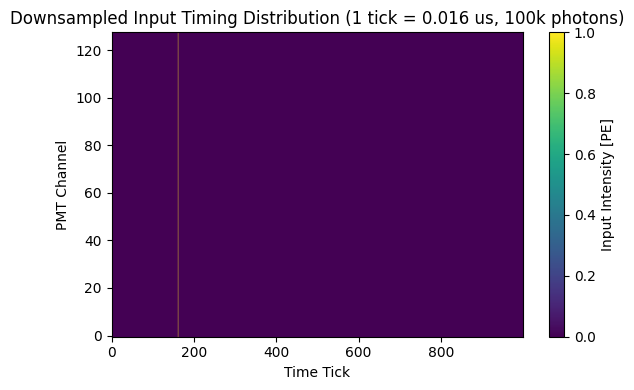

Outputs shape: torch.Size([128, 1000])


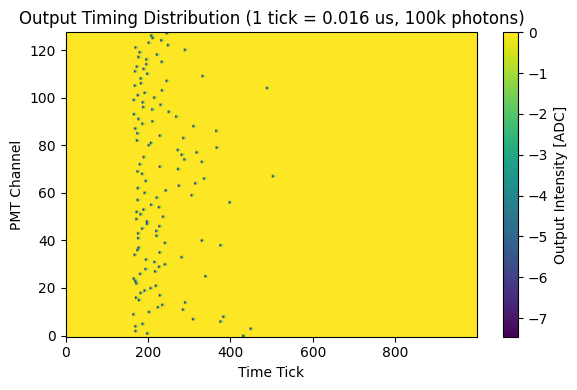

In [8]:
one_input = inputs[0]

# Testing one photon per pmt
one_input = torch.zeros((128, 16000))
one_input[:, 2560] = 1.0
output, info, delays = sim(one_input.to(device)) # (n_pmt, time_ticks)

# Plot an input
fig, ax = plt.subplots(figsize=(6, 4))
downsampled_input = sim.downsample_waveform(one_input.unsqueeze(0))
im0 = ax.imshow(downsampled_input.squeeze(0), aspect='auto', origin='lower', cmap='viridis')
fig.colorbar(im0, ax=ax, label='Input Intensity [PE]')
ax.set_xlabel("Time Tick")
ax.set_ylabel("PMT Channel")
ax.set_title(f"Downsampled Input Timing Distribution (1 tick = {sim.light_tick_size * 16} us, 100k photons)")
plt.tight_layout()
plt.show()

print("Outputs shape:", output.shape)
full_output = torch.sum(output, axis=0)
                        
fig, ax = plt.subplots(figsize=(6, 4))
im0 = ax.imshow(output.detach().cpu().numpy(), aspect='auto', origin='lower', cmap='viridis')
fig.colorbar(im0, ax=ax, label='Output Intensity [ADC]')
ax.set_xlabel("Time Tick")
ax.set_ylabel("PMT Channel")
ax.set_title(f"Output Timing Distribution (1 tick = {sim.light_tick_size * 16} us, 100k photons)")
# ax2 = ax.twinx()
# ax2.tick_params(axis='y', pad=-30) 
# ax2.plot(np.arange(output.shape[1]), full_output.cpu().detach().numpy(), color='black', linewidth=2, label='1D Waveform')
# ax2.legend(loc='upper right')
plt.tight_layout()
plt.show()

1e-09
128


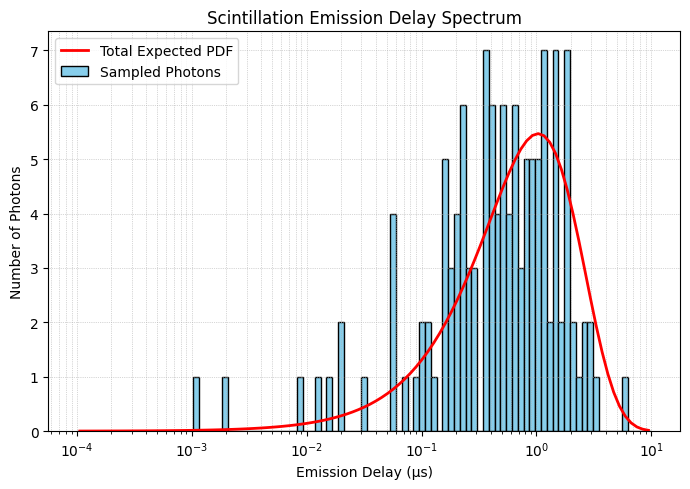

In [10]:
# Plotting same histogram with expected distributions

# Parameters from 'waveform_sim.yaml'
tau_s = sim.cfg.TAU_S
tau_t = sim.cfg.TAU_T
# singlet_frac = sim.cfg.NOMINAL_SINGLET_FRACTION
singlet_frac = sim.cfg.NOMINAL_SINGLET_FRACTION
triplet_frac = 1 - singlet_frac
print(singlet_frac)

# Define bins
bins = np.geomspace(1e-4, 10, 100)
emission_delays, _, info = sim.scintillation_model_sampled(one_input)
flat_delays = torch.cat(emission_delays).cpu().numpy()  # shape: (N,)
hist, bin_edges = np.histogram(flat_delays, bins=bins)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
bin_widths = bin_edges[1:] - bin_edges[:-1]

# calculating n_photons that reached pmt
photons_arrived = info['num_singlets'] + info['num_triplets']
print(photons_arrived)

# Compute scaled theoretical PDFs
pdf_s = (1 / tau_s) * np.exp(-bin_centers / tau_s)
pdf_t = (1 / tau_t) * np.exp(-bin_centers / tau_t)
pdf_s_scaled = pdf_s * singlet_frac * photons_arrived * bin_widths
pdf_t_scaled = pdf_t * triplet_frac * photons_arrived * bin_widths
total_scaled = pdf_s_scaled + pdf_t_scaled

# Plot
plt.figure(figsize=(7, 5))
plt.bar(bin_centers, hist, width=bin_widths, color='skyblue', edgecolor='black', align='center', label='Sampled Photons')
# plt.plot(bin_centers, pdf_s_scaled, color='orange', lw=2, label='Expected Singlet PDF')
# plt.plot(bin_centers, pdf_t_scaled, color='green', lw=2, label='Expected Triplet PDF')
plt.plot(bin_centers, total_scaled, color='red', lw=2, label='Total Expected PDF')

plt.xscale('log')
plt.xlabel('Emission Delay (μs)')
plt.ylabel('Number of Photons')
plt.title('Scintillation Emission Delay Spectrum')
plt.legend()
plt.grid(True, which='both', linestyle=':', linewidth=0.5)
plt.tight_layout()
plt.show()

In [11]:
from sirentv.sirentv.waveform import BatchedLightSimulation, mod0_sampler

# Including pdfs from sirentv to compare
sim_true = BatchedLightSimulation(cfg="../sirentv/templates/waveform_sim.yaml").to(device)
scintillation_true = sim_true.scintillation_model(one_input.to(device), relax_cut=False) # (ndet, nticks)
print(torch.sum(scintillation_true, dim=-1)[:5]) # bad

# output is not normalized, so normalize to treat it as pdf:
pdf = scintillation_true / scintillation_true.sum(dim=-1, keepdim=True)
print(torch.sum(pdf, dim=-1)[:5]) # good
print(pdf.shape)

BatchedLightSimulation Config:
	SINGLET_FRACTION: uniform(0.1, 0.5)
	LIGHT_OSCILLATION_PERIOD: uniform(0.05, 0.20)
	LIGHT_RESPONSE_TIME: uniform(0.01, 0.10)
	LIGHT_GAIN: uniform(-50.0, -20.0)
	TAU_S: uniform(0.0001, 0.01)
	TAU_T: uniform(0.9, 2.1)
	
	NOMINAL_SINGLET_FRACTION: 0.35
	NOMINAL_LIGHT_OSCILLATION_PERIOD: 0.11     # us
	NOMINAL_LIGHT_RESPONSE_TIME: 0.055         # us^-1
	NOMINAL_TAU_S: 0.001                       # us
	NOMINAL_TAU_T: 1.530                       # us
	NOMINAL_LIGHT_GAIN: -45.0                  # ADC us/pe
	
	LIGHT_TICK_SIZE: 0.001
	LIGHT_WINDOW: [1, 10]
tensor([2025.9447, 2025.9447, 2025.9447, 2025.9447, 2025.9447],
       device='cuda:0', grad_fn=<SliceBackward0>)
tensor([1., 1., 1., 1., 1.], device='cuda:0', grad_fn=<SliceBackward0>)
torch.Size([128, 16000])


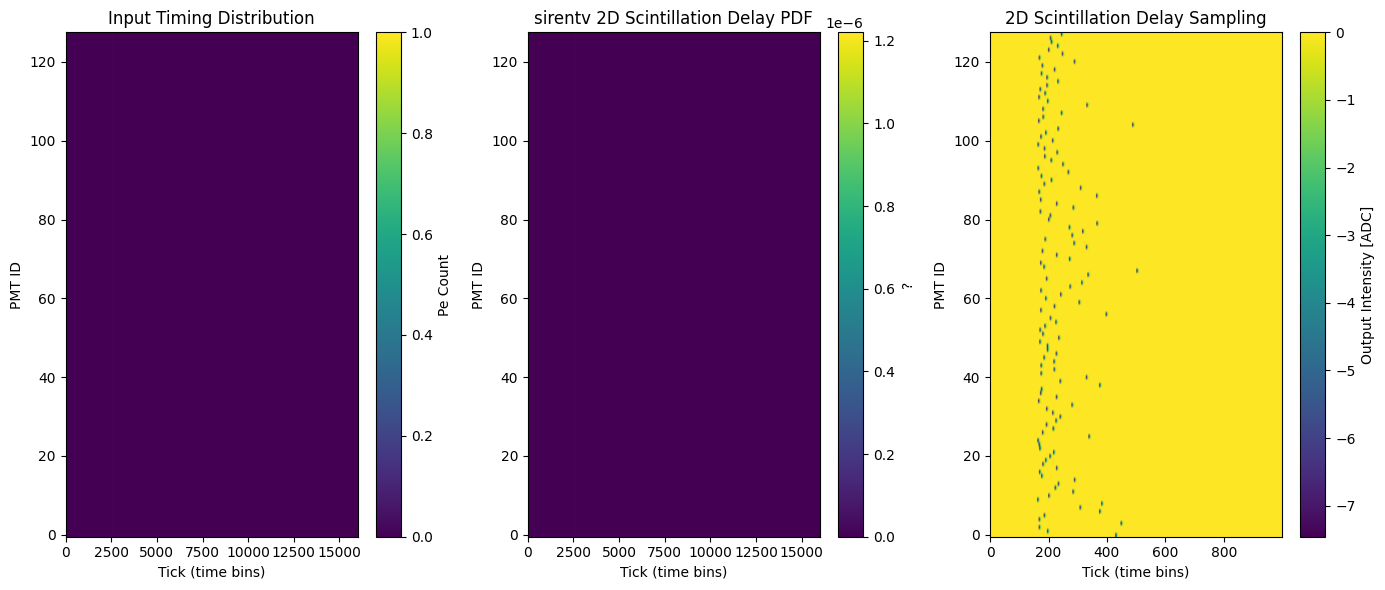

In [12]:
# Ensure both are on CPU and numpy
pdf_np = pdf.detach().cpu().numpy()  # shape: (ndet, nticks)
input_np = one_input.detach().cpu().numpy()  # shape: (ndet, nticks)

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(14, 6))

# Plot 1: Original input
im2 = axs[0].imshow(input_np, aspect='auto', origin='lower', cmap='viridis')
axs[0].set_title("Input Timing Distribution")
axs[0].set_xlabel("Tick (time bins)")
axs[0].set_ylabel("PMT ID")
fig.colorbar(im2, ax=axs[0], label="Pe Count")

# Plot 2: Scintillation delay PDF from sirentv
im1 = axs[1].imshow(pdf_np * input_np, aspect='auto', origin='lower', cmap='viridis')
axs[1].set_title("sirentv 2D Scintillation Delay PDF")
axs[1].set_xlabel("Tick (time bins)")
axs[1].set_ylabel("PMT ID")
fig.colorbar(im1, ax=axs[1], label="?")

# Plot 2: Scintillation delay PDF from sampling
im1 = axs[2].imshow(output.cpu().detach().numpy(), aspect='auto', origin='lower', cmap='viridis')
axs[2].set_title("2D Scintillation Delay Sampling")
axs[2].set_xlabel("Tick (time bins)")
axs[2].set_ylabel("PMT ID")
fig.colorbar(im1, ax=axs[2], label="Output Intensity [ADC]")

plt.tight_layout()
plt.show()

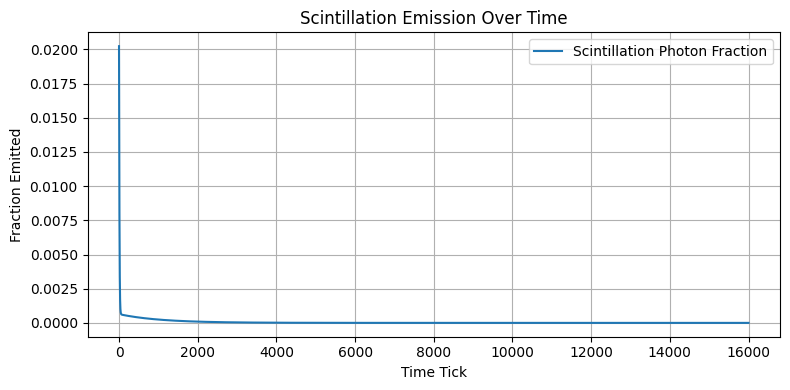

In [13]:
time_ticks = torch.arange(one_input.shape[1]).to(device)
fractions = sim.scintillation_model(time_ticks, relax_cut=True)

plt.figure(figsize=(8, 4))
plt.plot(time_ticks.cpu().numpy(), fractions.cpu().detach().numpy(), label="Scintillation Photon Fraction")
plt.xlabel("Time Tick")
plt.ylabel("Fraction Emitted")
plt.title("Scintillation Emission Over Time")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()